# Preparation

In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from trafficSimulator import *
import matplotlib.pyplot as plt

pygame 2.0.1 (SDL 2.0.14, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Simulation setup

### Simulation params setup

In [38]:
all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]

v_max = 15
s0 = 3
T = 1
b_max = 2.5
a_max = 1.5

vehicle_specs = {'v_max': v_max, # Desired speed
                 's0': s0, # Safe bumper-to-bumper distance
                 'T': T, # Time gap
                 'b_max': b_max, # Deceleartion
                 'a_max': a_max, # Acceleration
                }

vehicle_rate = 120
fast_track_factor, slow_track_factor = 1, 0.6
stop_distance = 40
wait_time = 1.5
vehicle_limit = 80

df = pd.DataFrame(columns=['Vehicle_label', 'Road_order', 
                           'Total_time', 'Leading_vehicles',
                           'Stopped_time', 'Stop_while_front'])

vehicle_preferences = dict(zip(range(vehicle_limit), 
                               [[0.25, 0.25, 0.25, 0.25]]*vehicle_limit))

### Topology setup

In [39]:
def parallel_line(current_coordinates, distance):
    """
    Returns the coordinate sets of lines that are parallel to the given line
    with the speicified distance
    
    Input:
        current_coordinates: two set of x and y coordinates that mark the start
                             and end of the given line
        distance: the distance between the given line and the parallel lines to
                  to be output
    """
    
    x1, y1 = current_coordinates[0]
    x2, y2 = current_coordinates[1]
    k = (y1-y2)/(x1-x2)
    b = y1 - k*x1
    
    cross_x = -b/k
    hypo = math.sqrt(b**2+cross_x**2)
    
    if k>0:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))

        new_coord_2 = ((x2-distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
        
    else:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
    
        new_coord_2 = ((x2-distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))
    
    return new_coord_1, new_coord_2

In [40]:
left, right = -100*math.sqrt(3), 100*math.sqrt(3)
bottom, top = -100, 100

left_bottom_outbound = ((left+2, 4), (-5, top-2),
                        slow_track_factor, stop_distance, wait_time)
bottom_right_outbound = ((5, top-2), (right-2, 4),
                         fast_track_factor, stop_distance, wait_time)

left_top_outbound = ((left+2, -4), (-5, bottom+2),
                     fast_track_factor, stop_distance, wait_time)
top_right_outbound = ((5, bottom+2), (right-2, -4),
                      slow_track_factor, stop_distance, wait_time)

bottom_left_inbound = parallel_line(current_coordinates=left_bottom_outbound, 
                                    distance=2.5)[0]
right_bottom_inbound = parallel_line(current_coordinates=bottom_right_outbound, 
                                     distance=2.5)[1]

top_left_inbound = parallel_line(current_coordinates=left_top_outbound, 
                                 distance=2.5)[0]
right_top_inbound = parallel_line(current_coordinates=top_right_outbound, 
                                  distance=2.5)[1]

## For the connections of the topology, we can either represent with concrete lines
## or just as a dot (as shown below). Either case, the vehicles will not actually go 
## pass these routes; they are more for demonstration purposes

connection_top_bottom = ((-1.25, bottom+2), (-1.25, top-2))
connection_bottom_top = ((1.25, top-2), (1.25, bottom+2))

# Or just show a dot:

# connection_top_bottom = ((-1.25, -2), (-1.25, 2))
# connection_bottom_top = ((1.25, 2), (1.25, -2))

### Utility params setup

In [41]:
# Smaller delta encourages more exploration
delta = 0.1

# Penalty proportion for delay caused
alpha = 0

# Interpolation factor between money and time
gamma_mean, gamma_var = 10, 5

# Level of risk aversion
eta_mean, eta_var = 1, 0.5

## Some functions needed

### For running simulation

In [42]:
 def run_simulation(round_number, all_routes, vehicle_limit, df, vehicle_preferences,
                    vehicle_rate, vehicle_specs):
    """
    Executes the simulation and returns certain data of the simulation.
    
    Input:
        round_number (integer): the number of the current simulation
        all_routes (list): all possible paths that a vehicle can take
        vehicle_limit (integer): the total number of vehicles in the simulation
        df (pandas DataFrame): a dataframe for storing data from the simulation
        vehicle_preferences (dict): store vehicle label as keys and their probabilities
                                    of choosing each of the possible routes as values
        vehicle_rate (integer): frequency of generating new vehicles
        vehicle_specs (dict): parameters related to the vehicles
    """
    global left_bottom_outbound
    global bottom_right_outbound
    global left_top_outbound
    global top_right_outbound
    global connection_top_bottom
    global connection_bottom_top
    global bottom_left_inbound
    global right_bottom_inbound
    global top_left_inbound
    global right_top_inbound
    
    records = df.copy()
    sim = Simulation({
        'round_number': round_number,
        'all_routes': all_routes, # All possible (and reasonable) routes
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'records': records, # Table that will capture the needed vehicle-related info
        'vehicle_preferences': vehicle_preferences
        # A dictionary that stores the vehicles' labels as keys and their list of probabilities
        # of choosing each possible route as values
        # For the initial few rounds all vehicles choose all routes with equal weights.
        # For more complicated topologies some other algorithms will be needed as all possible
        # routes are not as explicit as in here.
        })

    sim.create_roads([
        ## Key routes
        left_bottom_outbound, # Road #0
        bottom_right_outbound, # Road #1

        left_top_outbound, # Road #2
        top_right_outbound, # Road #3

        connection_top_bottom, # Road #4
        connection_bottom_top, # Road #5

#         bottom_left_inbound, # Road #6
#         right_bottom_inbound, # Road #7

#         top_left_inbound, # Road #8
#         right_top_inbound, # Road #9

        ## Curved corners
        # Note: in the simulation, the vehicles will not actually go pass these
        # routes; they are more for aesthetic purposes

        # Outbound corners
        *curve_road(left_bottom_outbound[1], 
                    (bottom_right_outbound[0][0], bottom_right_outbound[0][1]+0.01), 
                    (0, top), 16), # Outbound bottom corner

        *curve_road(left_top_outbound[1], 
                    (top_right_outbound[0][0], top_right_outbound[0][1]+0.01), 
                    (0, bottom), 16), # Outbound top corner

        *curve_road(left_bottom_outbound[0], 
                    (left_top_outbound[0][0]+0.01, left_top_outbound[0][1]), 
                    (left, 0), 16), # Outbound left corner

        *curve_road(bottom_right_outbound[1], 
                    (top_right_outbound[1][0]+0.01, top_right_outbound[1][1]), 
                    (right, 0), 16), # Outbound right corner

#         # Inbound corners
#         *curve_road(right_bottom_inbound[1], 
#                     (bottom_left_inbound[0][0], bottom_left_inbound[0][1]+0.01), 
#                     (0, top), 16), # Inbound bottom corner

#         *curve_road(right_top_inbound[1], 
#                     (top_left_inbound[0][0], top_left_inbound[0][1]+0.01), 
#                     (0, bottom), 16), # Inbound top corner

#         *curve_road(bottom_left_inbound[1], 
#                     (top_left_inbound[1][0]+0.01, top_left_inbound[1][1]), 
#                     (left+2.5, 0), 16), # Inbound left corner

#         *curve_road(right_bottom_inbound[0], 
#                     (right_top_inbound[0][0]+0.01, right_top_inbound[0][1]), 
#                     (right-2.5, 0), 16), # Inbound right corner
    ])


    sim.create_gen({
        'vehicle_rate': vehicle_rate, # Rate of generating new vehicles
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'vehicles': vehicle_specs
        })

    # Start simulation
    win = Window(sim)
    win.zoom = 3
    new_records = win.run(steps_per_update=5)
    
    return new_records

### For simulation result analysis

In [43]:
def utility_summary(record_df):
    """
    Returns a pivot table that summarizes the utility related features of each vehicle.
    
    Input:
        record_df (pandas DataFrame): records the simulation data of each vehicle
    
    """
    
    utility_tmp = record_df[['Vehicle_label', 'Road_order', 'Total_time']]

    utility_tmp['Caused_delay'] = 0.0
    utility_tmp.Total_time = pd.to_numeric(utility_tmp.Total_time)

    utility_tmp = utility_tmp.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)

    for idx, row in record_df.iterrows():
        current_l = row['Vehicle_label']
        stop_times = row['Stopped_time']
        lead_v = row['Leading_vehicles']
        route = row['Road_order']

        # For each vehicle's stop time, find its leading vehicle of the corresponding road segment
        # and assign the stop time to that vehicle as the time of delay that it causes
        for i in range(len(stop_times)):
            if stop_times[i] > 0:
                utility_tmp.at[lead_v[i], 'Caused_delay'] += stop_times[i]

        # Record the label of the routes taken
        for r in all_routes:
            if route == r:
                utility_tmp.at[idx, 'Road_order'] = all_routes.index(r)

    utility_tmp['Count'] = 1
    utility_tmp = pd.pivot_table(utility_tmp, 
                                 index=['Vehicle_label', 'Road_order'], 
                                 values=['Total_time', 'Caused_delay', 'Count'], 
                                 aggfunc={'Total_time': np.mean, # Average time taken for the past rounds
                                          'Caused_delay': np.mean, # Average delay caused for the
                                                                   # past rounds
                                          'Count': 'count'} # Count how many times the vehicle has taken
                                                            # the same routes
                                ).reset_index(drop=False)
    return utility_tmp

In [44]:
def compute_utility(explored_times,
                    time=0, 
                    caused_delay=0, 
                    alpha=0, 
                    gamma=0, 
                    eta=0, 
                    delta=0.1):
    """
    Returns the computed utility value
    
    Input:
        explored_times (integer): the number of times that the vehicle has taken the
                                  same route
        time (float): the amount of time taken to reach the destination
        caused_delay (float): the amount of delay that the vehicle has caused
        alpha (float): the penalty level
        gamma (float): the interpolation between money and time spent
        eta (float): the level of risk aversion
        delta (float): a parameter of the Upper Confidence Bound equation that controls
                       extent of encouraging exploration
    
    """
    
    if explored_times > 0:
        u_time = -np.log(time)
        u_penalty = -np.log(caused_delay*alpha)

        if eta == 1:
            u_total = gamma * u_time + u_penalty
        else:
            u_total = (np.exp(1-eta)-1) / (1-eta)
    else:
        u_total = 0
        
    u_total += np.sqrt(2*np.log(1/delta)/explored_times)
    return u_total

def compute_probability(utility_list):
    """
    Returns a list of probabilities of taking each route (using softmax)
    
    """
    prob_list = [np.exp(u) for u in utility_list]
    return [p/sum(prob_list) for p in prob_list]

In [45]:
def update_utility_df(record_df, df, utility_tmp, round_number=1):
    """
    Returns an updated dataframe that stores utility data of all vehicles
    
    """
    
    global all_routes
    utility_df = df.copy()
    
    for idx, row in utility_df.iterrows():
        i = row['Vehicle_label']
        utility_l = row['Utilities'][:]
        prob_l = row['Probabilities'][:]
        routes = row['Routes_taken'][:]
        gamma = row['Gamma']
        eta = row['Eta']

        for j in range(len(all_routes)):
            record = utility_tmp.loc[(utility_tmp.Vehicle_label==i) & (utility_tmp.Road_order==j)]
            if len(record) == 0:
                utility_l[j] = compute_utility(explored_times=0.01, delta=delta) # Exploration time is not integer here
                                                                                 # because utility will be infinite if
                                                                                 # it is 0 and it will cause problems in prob
                                                                                 # calculation
            else:
                utility_l[j] = compute_utility(explored_times=record['Count'].values[0], 
                                               time=record['Total_time'].values[0], 
                                               caused_delay=record['Caused_delay'].values[0], 
                                               alpha=alpha, 
                                               gamma=gamma, 
                                               eta=eta, 
                                               delta=delta)
    
        # Update probabilities of taking each route
        prob_l = compute_probability(utility_l)
        
        # Append the route chosen for the last round
        new_route_list = record_df.loc[(record_df.Vehicle_label==i) &
                                       (record_df.Round_number==round_number)]['Road_order'].values[0]
        new_route = all_routes.index(new_route_list)
        routes.append(new_route)
    
        # Update dataframe
        utility_df.at[idx, 'Utilities'] = utility_l
        utility_df.at[idx, 'Probabilities'] = prob_l
        utility_df.at[idx, 'Routes_taken'] = routes
    
    return utility_df

# Official start: 1st round

In [46]:
%%time
# Run the 1st round
record_df1 = run_simulation(1, all_routes, vehicle_limit, df, vehicle_preferences,
                             vehicle_rate, vehicle_specs)

Wall time: 55.1 s


In [47]:
record_df1

,Vehicle_label,Road_order,Total_time,Leading_vehicles,Stopped_time,Stop_while_front
0,68,"[0, 3]",34.9,"[-999, -999]","[0, 0]","[0, 0]"
1,30,"[2, 1]",25.25,"[-999, -999]","[0, 0]","[0, 0]"
2,21,"[2, 1]",27.7,"[30, 30]","[0, 0]","[0, 0]"
3,5,"[0, 1]",33.05,"[68, 21]","[0.25, 0]","[0.25, 0]"
4,42,"[2, 3]",38.1,"[21, 68]","[0, 0]","[0, 0]"
...,...,...,...,...,...,...
75,63,"[2, 3]",42.6,"[46, 3]","[0.1, 0]","[0, 0]"
76,9,"[0, 3]",46.8,"[77, 77]","[0.1, 0]","[0, 0]"
77,37,"[2, 1]",35.15,"[63, 39]","[0.15000000000000002, 0]","[0, 0]"
78,34,"[0, 3]",46.05,"[9, 9]","[0.15000000000000002, 0]","[0, 0]"


## Simulation Analysis of the 1st round

In [48]:
record_df1['Round_number'] = 1

record_df = record_df1.copy()
record_df.head(10)

,Vehicle_label,Road_order,Total_time,Leading_vehicles,Stopped_time,Stop_while_front,Round_number
0,68,"[0, 3]",34.9,"[-999, -999]","[0, 0]","[0, 0]",1
1,30,"[2, 1]",25.25,"[-999, -999]","[0, 0]","[0, 0]",1
2,21,"[2, 1]",27.7,"[30, 30]","[0, 0]","[0, 0]",1
3,5,"[0, 1]",33.05,"[68, 21]","[0.25, 0]","[0.25, 0]",1
4,42,"[2, 3]",38.1,"[21, 68]","[0, 0]","[0, 0]",1
5,6,"[0, 1]",34.65,"[5, 5]","[0, 0]","[0, 0]",1
6,53,"[2, 1]",36.6,"[42, 6]","[0, 0]","[0, 0]",1
7,58,"[0, 1]",39.35,"[6, 53]","[0.9500000000000003, 0]","[0.9500000000000003, 0]",1
8,75,"[2, 1]",41.7,"[53, 58]","[0.6, 0]","[0.6, 0]",1
9,29,"[0, 1]",47.45,"[58, 79]","[0.2, 0.1]","[0.2, 0]",1


### Set up dataframe

In [49]:
utility_df = pd.DataFrame(columns=['Vehicle_label', 'Utilities', 'Probabilities'])

utility_df['Vehicle_label'] = list(range(len(record_df.Vehicle_label.unique())))
utility_df['Routes_taken'] = [[]] * len(utility_df)
utility_df['Utilities'] = [[0] * len(all_routes)] * len(utility_df)
utility_df['Probabilities'] = [[0] * len(all_routes)] * len(utility_df)

In [50]:
etas = []
gammas = []

for i in range(len(utility_df)):
    eta = np.random.normal(eta_mean, eta_var, 1)[0]
    while eta < 0:
        eta = np.random.normal(eta_mean, eta_var, 1)[0]
    etas.append(eta)
    
for i in range(len(utility_df)):
    gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    while gamma < 0:
        gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    gammas.append(gamma)

utility_df['Gamma'] = gammas
utility_df['Eta'] = etas

utility_df = utility_df.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)            
utility_df.head(5)

,Vehicle_label,Utilities,Probabilities,Routes_taken,Gamma,Eta
0,0,"[0, 0, 0, 0]","[0, 0, 0, 0]",[],7.514855,0.558339
1,1,"[0, 0, 0, 0]","[0, 0, 0, 0]",[],5.912066,1.235819
2,2,"[0, 0, 0, 0]","[0, 0, 0, 0]",[],3.298875,1.219791
3,3,"[0, 0, 0, 0]","[0, 0, 0, 0]",[],8.684274,0.628066
4,4,"[0, 0, 0, 0]","[0, 0, 0, 0]",[],7.843976,0.372460


## Summary of the 1st round

In [51]:
utility_tmp = utility_summary(record_df)
utility_df = update_utility_df(record_df=record_df,
                               df=utility_df, 
                               utility_tmp=utility_tmp)

display(utility_tmp.head(10))
display(utility_df.head(10))

,Vehicle_label,Road_order,Caused_delay,Count,Total_time
0,0,0,0.05,1,56.75
1,1,3,0.55,1,39.25
2,2,3,0.05,1,60.05
3,3,1,0.05,1,46.20
4,4,2,0.15,1,51.40
5,5,1,0.00,1,33.05
6,6,3,0.95,1,34.65
7,7,1,0.15,1,56.75
8,8,3,0.10,1,51.30
9,9,1,0.15,1,46.80


,Vehicle_label,Utilities,Probabilities,Routes_taken,Gamma,Eta
0,0,"[3.4032389394125935, 23.177942091352516, 23.17...","[8.60665282475974e-10, 0.3333333330464449, 0.3...",[0],7.514855,0.558339
1,1,"[23.177942091352516, 23.177942091352516, 23.17...","[0.33333333313446206, 0.33333333313446206, 0.3...",[1],5.912066,1.235819
2,2,"[23.177942091352516, 23.177942091352516, 23.17...","[0.33333333313308616, 0.33333333313308616, 0.3...",[1],3.298875,1.219791
3,3,"[23.177942091352516, 3.3573023541092306, 23.17...","[0.3333333330593255, 8.220235869206179e-10, 0....",[2],8.684274,0.628066
4,4,"[23.177942091352516, 23.177942091352516, 3.537...","[0.33333333300535, 0.33333333300535, 9.8394998...",[1],7.843976,0.372460
5,5,"[23.177942091352516, 2.888396761534814, 23.177...","[0.3333333331618903, 5.143291843430905e-10, 0....",[1],9.462396,1.628457
6,6,"[23.177942091352516, 23.177942091352516, 23.17...","[0.33333333304190094, 0.33333333304190094, 0.3...",[1],12.811755,0.535235
7,7,"[23.177942091352516, 2.9417100886967593, 23.17...","[0.3333333331525021, 5.424938907507076e-10, 0....",[2],8.393319,1.475784
8,8,"[23.177942091352516, 23.177942091352516, 23.17...","[0.3333333331401607, 0.3333333331401607, 0.333...",[3],14.206397,1.305310
9,9,"[23.177942091352516, 3.157197852632656, 23.177...","[0.33333333310901814, 6.729456629776783e-10, 0...",[0],15.575029,0.977703


In [53]:
# # Export
record_df.to_csv("Saved_data/Simulation_records/Round_1.csv", index=False)
utility_df.to_csv("Saved_data/Utility_data/Round_1.csv", index=False)

# Run the remaining rounds
Utilities, probabilities are updated after each round and fed into the next round

In [54]:
# %%time

import time
time_l = []
begin = time.time()

# Updated probabilities for the 2nd round:
vehicle_preferences = dict(zip(range(vehicle_limit), utility_df.Probabilities.to_list()))

rounds = 100

for i in range(2, rounds+1):
    record_tmp = run_simulation(i, all_routes, 
                                vehicle_limit, 
                                df, vehicle_preferences,
                                vehicle_rate, vehicle_specs)
    record_tmp['Round_number'] = i
    
    record_df = pd.concat([record_df, record_tmp], ignore_index=True)
    
    utility_tmp = utility_summary(record_df)
    utility_df = update_utility_df(record_df=record_df,
                                   df=utility_df, 
                                   utility_tmp=utility_tmp,
                                   round_number=i)
    
    vehicle_preferences = dict(zip(range(vehicle_limit), 
                                   utility_df.Probabilities.to_list()))
    
    # Export
    record_df.to_csv(f"Saved_data/Simulation_records/Round_{i}.csv", index=False)
    utility_df.to_csv(f"Saved_data/Utility_data/Round_{i}.csv", index=False)
    
    time_l.append(round(time.time()-begin-sum(time_l), 2))

In [61]:
utility_tmp.to_csv(f"Saved_data/Simulation_records/Summary.csv", index=False)

In [56]:
sum(time_l)/60

113.96316666666667

In [18]:
record_df.tail(20)

,Vehicle_label,Road_order,Total_time,Leading_vehicles,Stopped_time,Stop_while_front,Round_number
280,11,"[0, 3]",57.34,"[3, 3]","[0, 0]","[0, 0]",19
281,10,"[2, 3]",47.9,"[4, 4]","[0, 0]","[0, 0]",19
282,1,"[2, 1]",42.44,"[10, 12]","[0, 0]","[0, 0]",19
283,0,"[0, 1]",49.2,"[11, 1]","[0, 0]","[0, 0]",19
284,6,"[2, 3]",55.92,"[1, 11]","[1.4800000000000009, 0.02]","[1.4800000000000009, 0]",19
285,14,"[2, 1]",31.4,"[-999, -999]","[0, 0]","[0, 0]",20
286,13,"[0, 3]",37.8,"[-999, -999]","[0, 0]","[0, 0]",20
287,9,"[0, 1]",35.28,"[13, 14]","[0, 0]","[0, 0]",20
288,8,"[2, 3]",40.22,"[14, 13]","[0, 0]","[0, 0]",20
289,12,"[2, 3]",43.46,"[8, 8]","[0, 0]","[0, 0]",20


# Visualization

In [42]:
# utility_df = pd.read_csv("Saved_data/Utility_data/Round_20.csv")
# record_df = pd.read_csv("Saved_data/Simulation_records/Round_20.csv")
# rounds = 20
# vehicle_limit = 25

In [41]:
# display(utility_df.head(10))
# display(record_df)

In [43]:
# import ast
# a = utility_df.Routes_taken[0]
# b = ast.literal_eval(a)
# b[0]

In [58]:
# utility_df.Routes_taken.to_list()[1]

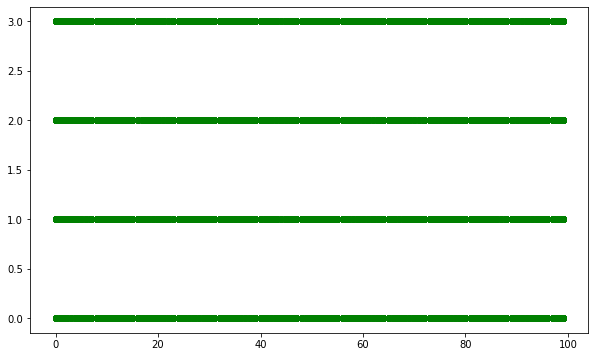

In [59]:
# gamma mean = 10
import ast
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(vehicle_limit):
#     route_list = ast.literal_eval(utility_df.Routes_taken.to_list()[i])
    route_list = utility_df.Routes_taken.to_list()[i]
    ax.scatter(range(rounds), route_list, alpha=0.5, color='g')
    
# ax.show()

# Others

In [4]:
# from scipy.io import loadmat
# eta_data = loadmat('data_mapEtas.mat')

# eta_data["mapEtaVals"]

array([[ 0.25006068,  1.44846975],
       [ 0.23771667,  1.5757056 ],
       [ 0.78201587,  2.06964125],
       [ 1.16306672,  1.48237096],
       [ 0.        ,  0.        ],
       [ 0.16372274,  0.80352242],
       [ 0.45853116,  1.31379466],
       [ 0.72514377,  1.76104585],
       [ 0.09113592,  1.12577703],
       [ 0.43634856,  1.1433241 ],
       [ 0.09392932,  1.20050842],
       [ 0.75444803,  1.51065275],
       [ 0.89657305,  1.45122475],
       [-0.17968388,  0.88363623],
       [ 0.37294569,  1.18797395],
       [ 0.35068067,  1.42035666],
       [-0.07431972,  1.3205315 ],
       [-0.07778457,  1.3046305 ],
       [ 0.23768834,  1.11844645]])